In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = (t-t0)/(n-1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    
    t and t0 are assumed to be constants.
    
    f is assumed to accept three arguments.
    
    The first is a constant giving the value of t.
    
    The second is a one-dimensional numpy array of the same size as y.
    
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    
    y is a constant or an array of size 1.
    
    It returns an array of shape (n, y.size) otherwise.
    
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

## Problem 1

In [31]:
# global variables
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_0 = 0
t_f = 50
n = 1000

In [32]:
# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])

costate = np.zeros((n,2))
costate0 = np.zeros(2)

u=np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
        
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the T cell concentration and the virus
        concentration at time t
    '''
    dT = s_1 - s_2 * y[1] / (B_1 + y[1]) - mu * y[0] - k * y[1] * y[0] + u[i,0] * y[0]
    dV = g * y[1] / (B_2 + y[1]) * (1 - u[i,1]) - c * y[1] * y[0]
    return np.array([dT,dV])

## Problem 2

In [11]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the lambda_hat values at time t
    i : int
        index for global variables, u and state.
        
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the lambda_hats at time t.
    '''
    d_l1 = y[0] * (-mu - k * state[-1-i,1] + u[-1-i,0]) - c * y[1] * state[-1-i,1] + 1
    d_l2 = -y[0] * ( (s_2 * B_1) / (B_1 + state[-1-i,1])**2 + k * state[-1-i,0]) + y[1] * ( (g * B_2 * (1 - u[-1-i,1])) / (B_2 + state[-1-i,1])**2 - c * state[-1-i,0])
    
    return np.array([d_l1,d_l2])

### Debug Output:: 

In [33]:
print(state_equations(10,[1,1],5))

state = RK4(state_equations, state0,0,t_f,n)

print(lambda_hat(10,[1,1],5))

[1.917975 1.493   ]
[ 1.018     -5.1135833]


## Problem 3

In [53]:
epsilon = 0.001
test = epsilon + 1
i = 0

while(test > epsilon and i < 100):
    oldu = u.copy();
    #solve the state equations with forward iteration
    state = RK4(state_equations,state0,t_0,t_f,n)

    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat,costate0,t_0,t_f,n)
    
    
    #solve for u1 and u2
    u1 = 1 / (2 * A_1) * costate[::-1,0] * state[:,0]
    u2 = -1 / (2 * A_2) * costate[::-1,1] * g * state[:,1] / (B_2 + state[:,1])
    
    # Bound u1, u2
    u1 = np.minimum(np.maximum(a_1,u1),b_1)
    u2 = np.minimum(np.maximum(a_2,u2),b_2)
    
    
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    
    #test for convergence
    test = abs(oldu - u).sum()
    print(test)
    i += 1

0.0005237293594374409


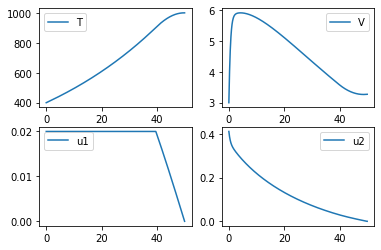

In [54]:
x = np.linspace(t_0,t_f,n)

# Print the resulting graphs
fig,ax = plt.subplots(nrows=2,ncols=2)

ax[0,0].plot(x,state[:,0],label="T")
ax[0,0].legend()

ax[0,1].plot(x,state[:,1],label="V")
ax[0,1].legend()

ax[1,0].plot(x,u[:,0],label="u1")
ax[1,0].legend()

ax[1,1].plot(x,u[:,1],label="u2")
ax[1,1].legend()

plt.show()